# 使用MMIO直接驱动测试
# 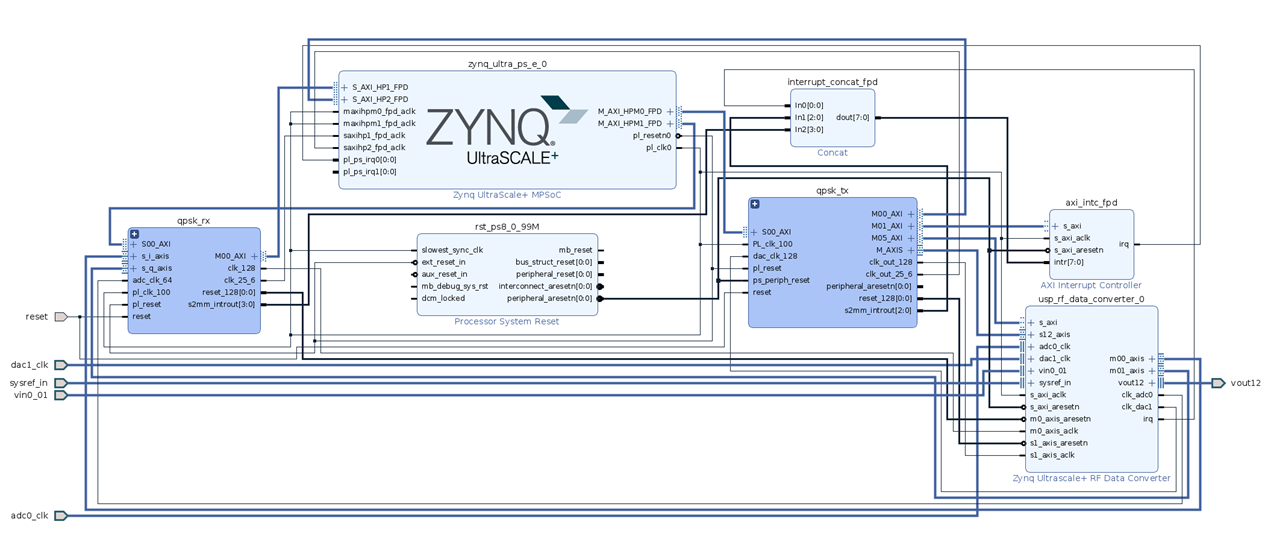
## 所有ADC和DAC时钟都使用409.6MHz

### #define AXI_QPSK_TX_TRANSFERTIME 0x3c/**< transfertime */
### #define AXI_QPSK_TX_TRANSFERSYMBOL 0x0/**< transfersymbol */
### #define AXI_QPSK_TX_TRANSFERFFT 0x4/**< transferfft */
### #define AXI_QPSK_TX_SIMULATEINTERFACE 0x40/**< simulateinterface */
### #define AXI_QPSK_TX_RESETTIME 0x30/**< resettime */
### #define AXI_QPSK_TX_RESETSYMBOL 0x8/**< resetsymbol */
### #define AXI_QPSK_TX_RESETFFT 0xc/**< resetfft */
### #define AXI_QPSK_TX_PACKETSIZETIME 0x34/**< packetsizetime */
### #define AXI_QPSK_TX_PACKETSIZESYMBOL 0x10/**< packetsizesymbol */
### #define AXI_QPSK_TX_PACKETSIZERF 0x14/**< packetsizerf */
### #define AXI_QPSK_TX_PACKETSIZEFFT 0x18/**< packetsizefft */
### #define AXI_QPSK_TX_OUTPUTGAIN 0x2c/**< outputgain */
### #define AXI_QPSK_TX_LFSR_RST 0x1c/**< lfsr_rst */
### #define AXI_QPSK_TX_ENABLE 0x20/**< enable */
### #define AXI_QPSK_TX_BYPASSGAIN 0x44/**< bypassgain */
### #define AXI_QPSK_TX_AUTORESTARTTIME 0x38/**< autorestarttime */
### #define AXI_QPSK_TX_AUTORESTARTSYMBOL 0x24/**< autorestartsymbol */
### #define AXI_QPSK_TX_AUTORESTARTFFT 0x28/**< autorestartfft */

## 注意lmx命名规则为LMXA2594_freq.txt

## step 0: 引用必要的库

In [1]:
import os
import xrfclk 

## step 1: 使用xrfclk的_find_devices() 方法找到系统的lmk,lmx设备

In [2]:
def find_lmclk_devices():
    xrfclk.xrfclk._find_devices()
find_lmclk_devices()

In [3]:
xrfclk.lmk_devices

[{'spi_device': PosixPath('/dev/spidev1.1'),
  'compatible': 'lmk04208',
  'num_bytes': 4}]

In [4]:
xrfclk.lmx_devices

[{'spi_device': PosixPath('/dev/spidev1.3'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.2'), 'compatible': 'lmx2594'},
 {'spi_device': PosixPath('/dev/spidev1.0'), 'compatible': 'lmx2594'}]

## step 2: 指定一个存储有时钟配置文件的位置，通常时钟配置文件放置在以lmk命名的文件夹里
### 例如时钟配置文件放置在 pynq/xrfclk/

In [5]:
loc = '/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk'

## step 3: 通常存在一个lmk，一至三个lmx

In [6]:
lmclk_loc = '' # 目录字符串
lmk_loc = ''   # 含文件名的完整路径字符串
lmx_locs = []  # 多个完整路径字符串列表

## step 4: 确定存在时钟配置txt文件的文件夹

In [7]:
for root, dirs, files in os.walk(loc):
        for d in dirs:
            for lmk in xrfclk.lmk_devices:
                if d == lmk['compatible']:
                    lmclk_loc = os.path.join(root, d)
                    break

In [8]:
lmclk_loc

'/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk/lmk04208'

## step 5: 存储所有lmk, lmx文件

In [9]:
for file in os.listdir(lmclk_loc):
        if file.endswith('.txt'):
            if 'LMK' in file:
                lmk_loc = os.path.join(lmclk_loc, file)
            elif 'LMX' in file:
                lmx_locs.append(os.path.join(lmclk_loc, file))
lmx_locs.sort()

In [10]:
lmk_loc

'/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk/lmk04208/LMK04208_122.88.txt'

In [11]:
lmx_locs

['/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk/lmk04208/LMXA2594_409.6.txt',
 '/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk/lmk04208/LMXB2594_409.6.txt',
 '/home/xilinx/jupyter_notebooks/rfsoc_qpsk/xrfclk/lmk04208/LMXC2594_409.6.txt']

## step 6: 存储lmk名称和频率值（MHz）和配置寄存器数据

In [12]:
lmk_name = lmk_loc.split('/')[-1]
lmk = lmk_name.strip('.txt').split('_')

with open(lmk_loc, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmk_reg = [int(r.split('\t')[-1], 16) for r in reg]

## step 7: 构建clk_props字典,仅lmk

In [13]:
clk_props = {
    'lmk': {
        'file': lmk_name,
        'loc':  lmk_loc,
        'chip': lmk[0],
        'freq': lmk[1],
        'reg':  lmk_reg
    }
}

## step 8: 存储所有lmx的名称，频率值，各存储器数据

In [14]:
lmxs = []
lmxs_reg = []
for lmx in lmx_locs:
    temp = lmx.split('/')[-1]
    lmx_split = temp.strip('.txt').split('_')
    lmxs.append(lmx_split)
    with open(lmx, 'r') as file:
        reg = [line.rstrip("\n") for line in file]
        lmxs_reg.append([int(r.split('\t')[-1], 16) for r in reg])

## step 9: 扩展clk_props字典，lmx关键字段用LMXA2594类似表示

In [15]:
for i in range(len(lmxs)):
    clk_props.update(
        {lmxs[i][0]: {                 # LMXA2594
            'file': lmxs[i][0],        # LMXA2594
            'loc' : lmx_locs[i],       # /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/xrfclk/lmk04208/LMXA2594_409.6.txt
            'chip': lmxs[i][0],        # LMXA2594
            'freq': lmxs[i][1],        # 409.6
            'reg' : lmxs_reg[i]        # 各寄存器数据
        }
        }
    )

## step 10: 配置lmk

In [16]:
for lmk in xrfclk.lmk_devices:
    xrfclk.xrfclk._write_LMK_regs(clk_props['lmk']['reg'], lmk)

## step 11: 配置lmxs

In [17]:
for i in range(len(lmxs)):
    xrfclk.xrfclk._write_LMX_regs(clk_props[lmxs[i][0]]['reg'], xrfclk.lmx_devices[i])

## step 12: 使能DC

In [18]:
import xrfdc

## step 13: 加载bit

In [19]:
from pynq import Overlay
qpsk_ol = Overlay('/usr/local/share/pynq-venv/lib/python3.10/site-packages/rfsoc_qpsk/rfsoc_qpsk/bitstream/rfsoc_qpsk.bit')
qpsk_ol.ip_dict

{'axi_intc_fpd': {'type': 'xilinx.com:ip:axi_intc:4.1',
  'mem_id': 's_axi',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_FAMILY': 'zynquplus',
   'C_INSTANCE': 'rfsoc_qpsk_axi_intc_fpd_0',
   'C_S_AXI_ADDR_WIDTH': '9',
   'C_S_AXI_DATA_WIDTH': '32',
   'C_NUM_INTR_INPUTS': '8',
   'C_NUM_SW_INTR': '0',
   'C_KIND_OF_INTR': '0xffffff00',
   'C_KIND_OF_EDGE': '0xFFFFFFFF',
   'C_KIND_OF_LVL': '0xFFFFFFFF',
   'C_ASYNC_INTR': '0xFFFFFFFF',
   'C_NUM_SYNC_FF': '2',
   'C_ADDR_WIDTH': '32',
   'C_IVAR_RESET_VALUE': '0x0000000000000010',
   'C_ENABLE_ASYNC': '0',
   'C_HAS_IPR': '1',
   'C_HAS_SIE': '1',
   'C_HAS_CIE': '1',
   'C_HAS_IVR': '1',
   'C_HAS_ILR': '0',
   'C_IRQ_IS_LEVEL': '1',
   'C_IRQ_ACTIVE': '0x1',
   'C_DISABLE_SYNCHRONIZERS': '0',
   'C_MB_CLK_NOT_CONNECTED': '1',
   'C_HAS_FAST': '0',
   'C_EN_CASCADE_MODE': '0',
   'C_CASCADE_MASTER': '0',
   'Component_Name': 'rfsoc_qpsk_axi_intc_fpd_0',
   'Sense_of_IRQ_Level_Type': 'Active_High',
 

## step 14: 使用MMIO驱动

In [20]:
from pynq import MMIO

In [21]:
qpsk_tx_mmio = MMIO(0xA0040000,0xffff)

In [22]:
gain = qpsk_tx_mmio.read(0xc)

In [23]:
gain

0